© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [ ]:
import math
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance

num_classes = 2
sns.set(style='white', context="poster", font='Work Sans Regural', palette=sns.color_palette(["#1F968BFF", "#FDE725FF", "#d1d3d4"], num_classes))

In [92]:
dataset = 'MIMIC'

models = [
    # os.path.join('SimCLR', dataset, '20230329-112506_l1_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.75.hdf5'),
    # os.path.join('SimCLR', dataset, '20230403-115302_200_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120645_e100_esFalse_bs128_wTrue_f2_fl', 'simclr.frozen.0.75.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120904_e100_esFalse_bs128_wTrue_f1_m', 'simclr.frozen.0.76.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121322_e100_esFalse_bs128_wTrue_f0', 'simclr.frozen.0.77.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121747_e100_esFalse_bs128_wTrue_f1', 'simclr.frozen.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122120_e100_esFalse_bs128_wTrue_f2', 'simclr.frozen.0.69.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122444_e100_esFalse_bs128_wTrue_f3', 'simclr.frozen.0.78.hdf5'),
    os.path.join('Supervised', dataset, '20230403-133103_l2_e100_esFalse_bs128_wTrue', 'supervised.finetuned.0.81.hdf5')
]
intermediate_layer = 7  # last CNN layer

In [130]:
model_file_name = models[-1]
model_name = 'sup'
test = (np.load(os.path.join('SimCLR', dataset, 'test_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'test_y.npy')))

In [131]:
test_listfile = pd.read_csv(os.path.join('..', '..', 'datasets', dataset, 'test_listfile.csv'))
subjects = pd.read_csv(os.path.join('..', '..',  'datasets', dataset, 'demographics_rich.csv'))
# extract subject_id from stay
regex = r"(?:^\d+)"
test_listfile.loc[:, "SUBJECT_ID"] = test_listfile.stay.apply(lambda stay: re.search(regex, stay).group(0))
test_listfile.SUBJECT_ID = test_listfile.SUBJECT_ID.astype(int)
test_listfile.drop(['stay'], axis=1, inplace=True)
test_listfile = test_listfile.merge(subjects, how='left', on='SUBJECT_ID')
test_listfile.head()

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0


# All (random) users test -> Gender-based coloring

In [132]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
# predictions
np_test = (np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_x.npy')),
           np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_y.npy')))
probs = model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
test_listfile.loc[:, "y_pred"] = predictions

# representations
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(test[0], batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()

(3236, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

In [133]:
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42, n_iter=5000)
projected_X = tsne_model.fit_transform(intermediate_representation)
projected_X

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3236 samples in 0.001s...
[t-SNE] Computed neighbors for 3236 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3236
[t-SNE] Computed conditional probabilities for sample 2000 / 3236
[t-SNE] Computed conditional probabilities for sample 3000 / 3236
[t-SNE] Computed conditional probabilities for sample 3236 / 3236
[t-SNE] Mean sigma: 0.256870
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.491852
[t-SNE] KL divergence after 5000 iterations: 1.697865


array([[-45.98843  ,  29.951492 ],
       [-21.586039 ,  13.601299 ],
       [ 13.57492  , -37.653614 ],
       ...,
       [  3.9029057,   9.948571 ],
       [ 33.481224 ,  -3.445493 ],
       [-38.64619  ,  44.537823 ]], dtype=float32)

In [135]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,y_pred
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,1.0
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,0.0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,0.0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,0.0
...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.0
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.0
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.0
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.0


In [136]:
def color_encoding_gender(prot_attr, colored_attribute, y_pred):
    if prot_attr != colored_attribute:
        return 'ŷ ({})'.format('F' if colored_attribute == 'M' else 'M')
    elif y_pred == 1:
        return '1 ({})'.format(colored_attribute)
    else:
        return '0 ({})'.format(colored_attribute)

# <65 (1)
def color_encoding_age(prot_attr, colored_attribute, y_pred):
    prot_attr = ('<65' if prot_attr == 1 else '>=65')
    if prot_attr != colored_attribute:
        return 'ŷ ({})'.format('<65' if colored_attribute == '>=65' else '>=65')
    elif y_pred == 1:
        return '1 ({})'.format(colored_attribute)
    else:
        return '0 ({})'.format(colored_attribute)

test_listfile.loc[:, "color_encoding_gender"] = test_listfile.apply(lambda row: color_encoding_gender(row['GENDER'], 'M', row['y_pred']), axis=1)
test_listfile.loc[:, "color_encoding_age"] = test_listfile.apply(lambda row: color_encoding_age(row['AGE'], '<65', row['y_pred']), axis=1)
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,y_pred,color_encoding_gender,color_encoding_age
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1,1.0,ŷ (F),1 (<65)
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0,0.0,ŷ (F),ŷ (>=65)
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0,0.0,0 (M),ŷ (>=65)
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0,0.0,0 (M),ŷ (>=65)
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0,0.0,0 (M),ŷ (>=65)
...,...,...,...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1,0.0,0 (M),0 (<65)
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.0,0 (M),ŷ (>=65)
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1,0.0,0 (M),0 (<65)
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0,0.0,0 (M),ŷ (>=65)


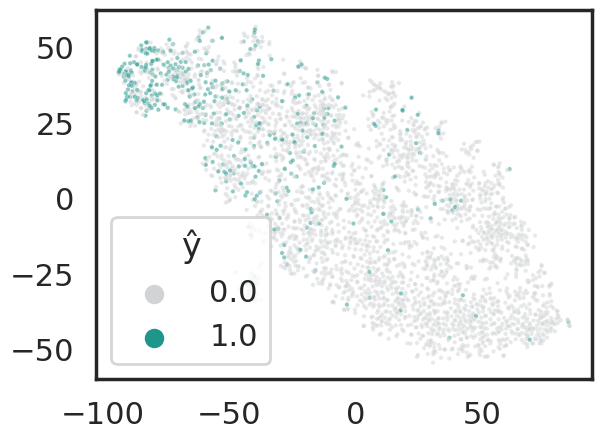

In [137]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test_listfile["y_pred"],
    # hue_order =
    palette=sns.color_palette(["#d1d3d4", "#1F968BFF"]),
    legend="full",
    s=10,
    alpha=0.5,
)

plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-labels.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

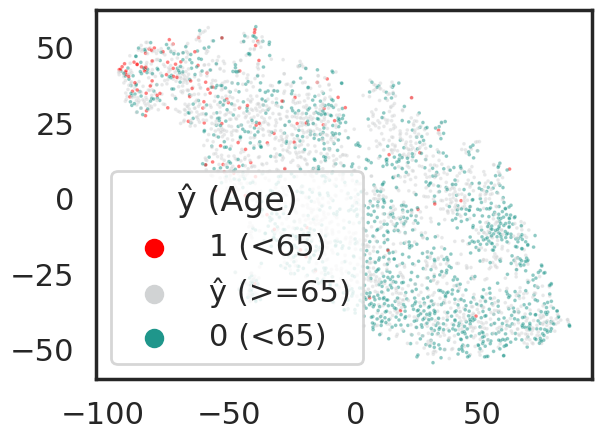

In [146]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test_listfile["color_encoding_age"],
    # hue_order =
    palette=sns.color_palette(["red", "#d1d3d4", "#1F968BFF", ]),
    legend="full",
    s=7,
    alpha=0.5,
)

plt.legend(title='ŷ (Age)')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-less65-go.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

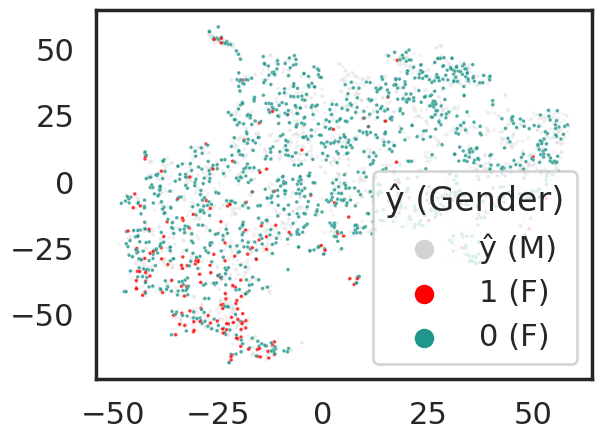

In [84]:
plt.clf()
ax = sns.scatterplot(
    x=projected_X[test_listfile.GENDER == "M",0], y=projected_X[test_listfile.GENDER == "M",1],
    hue=test_listfile.loc[test_listfile.GENDER == "M", "color_encoding_gender"],
    palette=sns.color_palette(["#d1d3d4"]),
    legend="full",
    s=7,
    alpha=0.3,
)
graph = sns.scatterplot(
    x=projected_X[test_listfile.GENDER == "F",0], y=projected_X[test_listfile.GENDER == "F",1],
    hue=test_listfile.loc[test_listfile.GENDER == "F", "color_encoding_gender"],
    palette=sns.color_palette(["red", "#1F968BFF" ]),
    legend="full",
    s=7,
    alpha=0.8,
    ax=ax
)
# "#FDE725FF"
# graph = sns.scatterplot(
#     x=projected_X[:,0], y=projected_X[:,1],
#     hue=test_listfile["color_encoding_gender"],
#     palette=sns.color_palette(["#d1d3d4", "#1F968BFF", "#FDE725FF"]),
#     legend="full",
#     s=10,
#     alpha=0.5,
# )

plt.legend(title='ŷ (Gender)')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-7-f-go.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

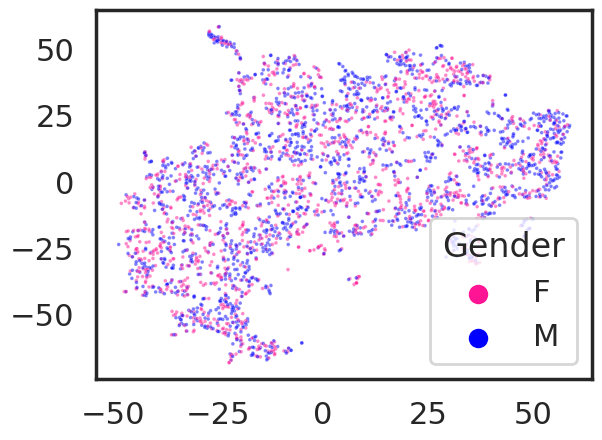

In [136]:
plt.clf()
color_coding = test_listfile["color_encoding_gender"].apply(lambda c: "F" if c=="ŷ (F)" else "M")
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=color_coding,
    palette=sns.color_palette(["deeppink", "blue"]),
    legend="full",
    s=7,
    alpha=0.5,
)

plt.legend(title='Gender')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-m-f.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Row Separation

In [384]:
test_listfile.GENDER.value_counts()

M    1797
F    1439
Name: GENDER, dtype: int64

In [139]:
male_rows = test_listfile.index[test_listfile["GENDER"] == "M"].tolist()
female_rows = test_listfile.index[test_listfile["GENDER"] == "F"].tolist()
print("Male rows: {} and Female rows: {}".format(len(male_rows), len(female_rows)))

Male rows: 1797 and Female rows: 1439


In [386]:
test_listfile.INSURANCE.value_counts()

Medicare      1903
Private        978
Medicaid       236
Government      83
Self Pay        36
Name: INSURANCE, dtype: int64

In [14]:
medicare_rows = test_listfile.index[test_listfile["INSURANCE"] == "Medicare"].tolist()
private_rows = test_listfile.index[test_listfile["INSURANCE"] == "Private"].tolist()
medicaid_rows = test_listfile.index[test_listfile["INSURANCE"] == "Medicaid"].tolist()
government_rows = test_listfile.index[test_listfile["INSURANCE"] == "Government"].tolist()
selfpay_rows = test_listfile.index[test_listfile["INSURANCE"] == "Self Pay"].tolist()
print("Medicare: {} - Private: {} - Medicaid: {} - Government: {} - Self Pay: {}".format(len(medicare_rows), len(private_rows), len(medicaid_rows), len(government_rows), len(selfpay_rows)))

Medicare: 1903 - Private: 978 - Medicaid: 236 - Government: 83 - Self Pay: 36


In [483]:
test_listfile.AGE.value_counts()

0    1796
1    1440
Name: AGE, dtype: int64

In [484]:
age0_rows = test_listfile.index[test_listfile["AGE"] == 0].tolist()
age1_rows = test_listfile.index[test_listfile["AGE"] == 1].tolist()

In [147]:
test_listfile.ETHNICITY.value_counts()
white_rows = test_listfile.index[test_listfile["ETHNICITY"].str.contains("WHITE")].tolist()
black_rows = test_listfile.index[test_listfile["ETHNICITY"].str.contains("BLACK")].tolist()
hispanic_rows = test_listfile.index[test_listfile["ETHNICITY"].str.contains("HISPANIC")].tolist()
asian_rows = test_listfile.index[test_listfile["ETHNICITY"].str.contains("ASIAN")].tolist()

In [492]:
test_listfile.LANGUAGE.value_counts()
english_rows = test_listfile.index[test_listfile["LANGUAGE"] == "ENGL"].tolist()
nonenglish_rows = test_listfile.index[test_listfile["LANGUAGE"] != "ENGL"].tolist()

## Distances for insurance

In [475]:
def get_median(x_subset, y_subset=None):
    if y_subset is None:
        return np.median(x_subset)
    else:
        return np.median(x_subset), np.median(y_subset)

def get_mean(arr_subset):
    return arr_subset.mean(axis=0)

In [502]:
# why is Manhattan distance preferred: https://bib.dbvis.de/uploadedFiles/155.pdf
from sklearn_extra.cluster import KMedoids
# why is Manhattan distance preferred: https://bib.dbvis.de/uploadedFiles/155.pdf
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_medicare_or = GetMedoid(intermediate_representation[medicare_rows, :])
medoid_private_or = GetMedoid(intermediate_representation[private_rows, :])
medoid_government_or = GetMedoid(intermediate_representation[government_rows, :])
medoid_medicaid_or = GetMedoid(intermediate_representation[medicaid_rows, :])
medoid_selfpay_or = GetMedoid(intermediate_representation[selfpay_rows, :])
dist = distance.cityblock(medoid_selfpay_or, medoid_medicaid_or) + distance.cityblock(medoid_medicaid_or, medoid_government_or) + distance.cityblock(medoid_medicaid_or, medoid_private_or) + distance.cityblock(medoid_medicaid_or, medoid_medicare_or)
avg_dist = dist/4
print("Total: {} - Average: {}".format(dist, avg_dist))

Total: 18.96361541748047 - Average: 4.740903854370117


In [503]:
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_m_or = GetMedoid(intermediate_representation[male_rows, :])
medoid_f_or = GetMedoid(intermediate_representation[female_rows, :])
dist = distance.cityblock(medoid_m_or, medoid_f_or) 
avg_dist = dist
print("Total: {} - Average: {}".format(dist, avg_dist))

Total: 4.126715183258057 - Average: 4.126715183258057


In [504]:
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_m_or = GetMedoid(intermediate_representation[age0_rows, :])
medoid_f_or = GetMedoid(intermediate_representation[age1_rows, :])
dist = distance.cityblock(medoid_m_or, medoid_f_or) 
avg_dist = dist
print("Total: {} - Average: {}".format(dist, avg_dist))

Total: 3.772526502609253 - Average: 3.772526502609253


In [505]:
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_white_or = GetMedoid(intermediate_representation[white_rows, :])
medoid_black_or = GetMedoid(intermediate_representation[black_rows, :])
medoid_asian_or = GetMedoid(intermediate_representation[asian_rows, :])
medoid_hispanic_or = GetMedoid(intermediate_representation[hispanic_rows, :])
dist = distance.cityblock(medoid_black_or, medoid_white_or) + distance.cityblock(medoid_black_or, medoid_hispanic_or) + distance.cityblock(medoid_black_or, medoid_asian_or) 
avg_dist = dist/3
print("Total: {} - Average: {}".format(dist, avg_dist))

Total: 15.382835388183594 - Average: 5.127611796061198


In [506]:
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_e_or = GetMedoid(intermediate_representation[english_rows, :])
medoid_ne_or = GetMedoid(intermediate_representation[nonenglish_rows, :])
dist = distance.cityblock(medoid_e_or, medoid_ne_or) 
avg_dist = dist
print("Total: {} - Average: {}".format(dist, avg_dist))

Total: 3.817601203918457 - Average: 3.817601203918457


In [406]:
mean_medicare_or = get_mean(intermediate_representation[medicare_rows, :])
mean_private_or = get_mean(intermediate_representation[private_rows, :])
mean_government_or = get_mean(intermediate_representation[government_rows, :])
mean_medicaid_or = get_mean(intermediate_representation[medicaid_rows, :])
mean_selfpay_or = get_mean(intermediate_representation[selfpay_rows, :])
dist = distance.cityblock(mean_selfpay_or, mean_medicaid_or) + distance.cityblock(mean_medicaid_or, mean_government_or) + distance.cityblock(mean_medicaid_or, mean_private_or) + distance.cityblock(mean_medicaid_or, mean_medicare_or)
dist

24.683247

In [407]:
med_medicare_or = get_median(intermediate_representation[medicare_rows, :])
med_private_or = get_median(intermediate_representation[private_rows, :])
med_government_or = get_median(intermediate_representation[government_rows, :])
med_medicaid_or = get_median(intermediate_representation[medicaid_rows, :])
med_selfpay_or = get_median(intermediate_representation[selfpay_rows, :])
dist = distance.cityblock(med_selfpay_or, med_medicaid_or) + distance.cityblock(med_medicaid_or, med_government_or) + distance.cityblock(med_medicaid_or, med_private_or) + distance.cityblock(med_medicaid_or, med_medicare_or)
dist

0.0

## Median Female vs Median Male

In [116]:
# Before dimensionality reduction -> find the mean point (centroid)
f_median = get_median(intermediate_representation[female_rows,:])
f_median = np.reshape(f_median, (1,-1))
m_median = get_median(intermediate_representation[male_rows,:])
m_median = np.reshape(m_median, (1,-1))

In [117]:
print("Distance between median male and female in the original space: {}".format(distance.cityblock(f_median, m_median)))

Distance between median male and female in the original space: 0.0


In [94]:
f_x_median, f_y_median = get_median(projected_X[female_rows,0], projected_X[female_rows,1])
print("Female x: {} and y: {}".format(f_x_median, f_y_median))
m_x_median, m_y_median = get_median(projected_X[male_rows,0], projected_X[male_rows,1])
print("Male x: {} and y: {}".format(m_x_median, m_y_median))

Female x: -4.698515892028809 and y: 0.5477921962738037
Male x: 3.4323225021362305 and y: -1.9354749917984009


In [95]:
print("Distance between median male and female in the lower-dimensional space: {}".format(distance.cityblock([f_x_median, f_y_median], [m_x_median, m_y_median])))

Distance between median male and female in the lower-dimensional space: 10.614105224609375


## Mean Female vs Mean Male

In [118]:
# Before dimensionality reduction -> find the mean point (centroid)
f_mean = get_mean(intermediate_representation[female_rows,:])
f_mean = np.reshape(f_mean, (1,-1))
m_mean = get_mean(intermediate_representation[male_rows,:])
m_mean = np.reshape(m_mean, (1,-1))

In [119]:
print("Distance between mean male and female in the original space: {}".format(distance.cityblock(f_mean, m_mean)))

Distance between mean male and female in the original space: 6.571095943450928


In [ ]:
f_x_mean, f_y_mean = get_median(projected_X[female_rows,0], projected_X[female_rows,1])
print("Female x: {} and y: {}".format(f_x_median, f_y_median))
m_x_mean, m_y_mean = get_median(projected_X[male_rows,0], projected_X[male_rows,1])
print("Male x: {} and y: {}".format(m_x_median, m_y_median))

In [ ]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(f_x_median, f_y_median, c='deeppink', marker='P', s=70)
plt.text(f_x_median * (1 + 1.1), f_y_median * (1 + 1.1) , "F", fontsize=12)
mp = plt.scatter(m_x_median, m_y_median, c='darkblue', marker='D', s=70)
plt.text(m_x_median * (1 + 1.3), m_y_median * (1 + 1.3) , "M", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender_median.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Medoid <65 vs >=65

In [329]:
less65_rows = test_listfile.index[test_listfile["AGE"] == 1].tolist()
greater65_rows = test_listfile.index[test_listfile["AGE"] == 0].tolist()
print("<65 rows: {} and >=65 rows: {}".format(len(less65_rows), len(greater65_rows)))

<65 rows: 1440 and >=65 rows: 1796


In [330]:
# Before dimensionality reduction -> find the mean point (centroid)
print("X shape: {}".format(intermediate_representation.shape))
f_mean = get_mean(intermediate_representation[greater65_rows,:])
f_mean = np.reshape(f_mean, (1,-1))
m_mean = get_mean(intermediate_representation[less65_rows,:])
m_mean = np.reshape(m_mean, (1,-1))
print(f_mean.shape)

X shape: (3236, 96)
(1, 96)


In [331]:
# Before dimensionality reduction -> find the closest existing point to the mean (possibly medoid)
# print("Centroid shape: {} - Data shape: {}".format(f_mean.shape, intermediate_representation[female_rows,:].shape))
closest_f_index, closest_f_dist = pairwise_distances_argmin_min(f_mean, intermediate_representation[greater65_rows,:])
closest_f = intermediate_representation[closest_f_index,:]
# print("Point closest to the female centroid: {}".format(closest_f))
closest_m_index, closest_m_dist = pairwise_distances_argmin_min(m_mean, intermediate_representation[less65_rows,:])
closest_m = intermediate_representation[closest_m_index,:]

In [332]:

from scipy.spatial.distance import cityblock
print("Euclidean Distance between medoid <65 and >=65 in the original space (not appropriate for high dimensions): {}".format(distance.euclidean(closest_f, closest_m)))
print("Manhattan Distance between medoid <65 and >=65 in the original space: {}".format(distance.cityblock(closest_f, closest_m)))

Euclidean Distance between medoid <65 and >=65 in the original space (not appropriate for high dimensions): 4.037208080291748
Manhattan Distance between medoid <65 and >=65 in the original space: 18.005245208740234


In [333]:
# in the lower-dimensional space -> find the medoid equivalent
f_projections = projected_X[greater65_rows, :]
closest_f_tsne = f_projections[closest_f_index, :]
print(">=65 medoid: {}".format(closest_f_tsne))
m_projections = projected_X[less65_rows, :]
closest_m_tsne = m_projections[closest_m_index, :]
print("<65 medoid: {}".format(closest_m_tsne))

>=65 medoid: [[ 6.263501  -2.2674255]]
<65 medoid: [[ -4.023616 -10.414501]]


In [334]:
# reshaping
closest_m_tsne = np.reshape(closest_m_tsne, (-1,))
closest_f_tsne = np.reshape(closest_f_tsne, (-1,))
closest_m_tsne.shape

(2,)

In [335]:
print("Euclidean Distance between medoid <65 and >=65 in the lower dimensional space: {}".format(distance.euclidean(closest_f_tsne, closest_m_tsne)))
print("Manhattan Distance between medoid <65 and >=65 in the lower dimensional space: {}".format(distance.cityblock(closest_f_tsne, closest_m_tsne)))

Euclidean Distance between medoid <65 and >=65 in the lower dimensional space: 13.122485160827637
Manhattan Distance between medoid <65 and >=65 in the lower dimensional space: 18.434192657470703


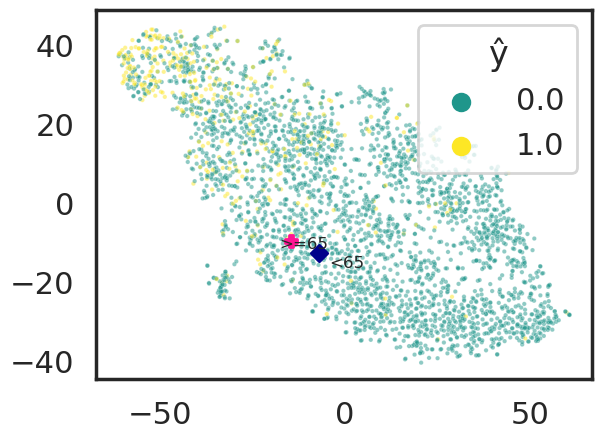

In [312]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(closest_f_tsne[0], closest_f_tsne[1], c='deeppink', marker='P', s=70)
plt.text(closest_f_tsne[0] * (1 + 0.2), closest_f_tsne[1] * (1 + 0.2) , ">=65", fontsize=12)
mp = plt.scatter(closest_m_tsne[0], closest_m_tsne[1], c='darkblue', marker='D', s=70)
plt.text(closest_m_tsne[0] * (1 -0.4), closest_m_tsne[1] * (1 + 0.3) , "<65", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-age-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## kNN-based Female vs Male

In [159]:
from sklearn.neighbors import NearestNeighbors
def nearest_lookup(data):
    print (data.shape)
    nns = NearestNeighbors(n_neighbors=6).fit(data)
    distances, indices = nns.kneighbors(data)
    return distances, indices

In [160]:
# Female
distances_emb, indices_emb = nearest_lookup(intermediate_representation[female_rows,:])
distances_orig, indices_orig = nearest_lookup(projected_X[female_rows, :])

(1439, 96)
(1439, 2)


We cannot perform this method because we are not looking for the points closest to another point, rather the medoid point of a set of points

## Medoid Female vs Male (with StackOverflow Implementation)

In [56]:
# why is Manhattan distance preferred: https://bib.dbvis.de/uploadedFiles/155.pdf
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_f_or = GetMedoid(intermediate_representation[female_rows,:])
medoid_m_or = GetMedoid(intermediate_representation[male_rows,:])

In [57]:
from scipy.spatial import distance
from scipy.spatial.distance import cityblock
print("Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): {}".format(distance.euclidean(medoid_f_or, medoid_m_or)))
print("Manhattan Distance between median male and female in the original space: {}".format(distance.cityblock(medoid_f_or, medoid_m_or)))

Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): 1.8321939706802368
Manhattan Distance between median male and female in the original space: 7.270665168762207


In [58]:
medoid_f = GetMedoid(projected_X[female_rows, :])
medoid_m = GetMedoid(projected_X[male_rows, :])
print("Euclidean Distance between median male and female in the lower-dimensional space (not appropriate for high dimensions): {}".format(distance.euclidean(medoid_f, medoid_m)))
print("Manhattan Distance between median male and female in the lower-dimensional space: {}".format(distance.cityblock(medoid_f, medoid_m)))

Euclidean Distance between median male and female in the lower-dimensional space (not appropriate for high dimensions): 8.967315673828125
Manhattan Distance between median male and female in the lower-dimensional space: 12.271098136901855


In [59]:
medoid_f[0,0]

-5.703486

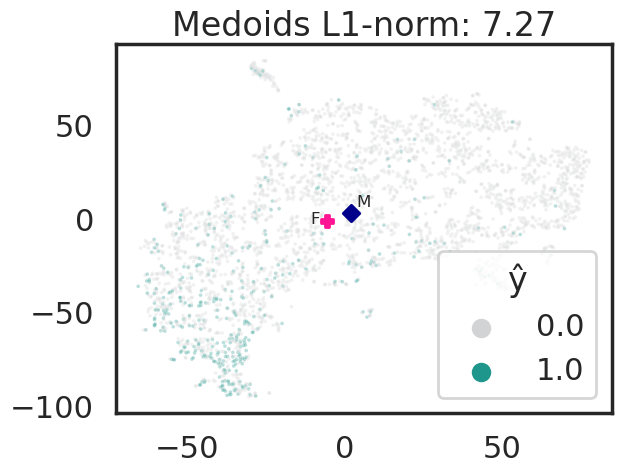

In [61]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#d1d3d4", "#1F968BFF"]),
    legend="full",
    s=7,
    alpha=0.3,
)
fp = plt.scatter(medoid_f[0,0], medoid_f[0,1], c='deeppink', marker='P', s=70)
plt.text(medoid_f[0,0] * (1 + 0.9), medoid_f[0,1] * (1 + 0.9) , "F", fontsize=12)
mp = plt.scatter(medoid_m[0,0], medoid_m[0,1], c='darkblue', marker='D', s=70)
plt.text(medoid_m[0,0] * (1 + 0.9), medoid_m[0,1] * (1 + 1) , "M", fontsize=12)
plt.legend(title='ŷ')
dist = distance.cityblock(medoid_f_or, medoid_m_or)
plt.title('Medoids L1-norm: {}'.format("%.2f" % dist))
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Medoids Insurance

In [455]:
# why is Manhattan distance preferred: https://bib.dbvis.de/uploadedFiles/155.pdf
medoid_medicare_or = GetMedoid(intermediate_representation[medicare_rows,:])
medoid_private_or = GetMedoid(intermediate_representation[private_rows,:])
medoid_government_or = GetMedoid(intermediate_representation[government_rows,:])
medoid_medicaid_or = GetMedoid(intermediate_representation[medicaid_rows,:])
medoid_selfpay_or = GetMedoid(intermediate_representation[selfpay_rows,:])

In [456]:
dist = distance.cityblock(medoid_selfpay_or, medoid_medicaid_or) + distance.cityblock(medoid_medicaid_or, medoid_government_or) + distance.cityblock(medoid_medicaid_or, medoid_private_or) + distance.cityblock(medoid_medicaid_or, medoid_medicare_or) 
dist

35.626087

In [457]:
medoid_medicare = GetMedoid(projected_X[medicare_rows, :])
medoid_private = GetMedoid(projected_X[private_rows, :])
medoid_government = GetMedoid(projected_X[government_rows, :])
medoid_medicaid = GetMedoid(projected_X[medicaid_rows, :])
medoid_selfpay = GetMedoid(projected_X[selfpay_rows, :])

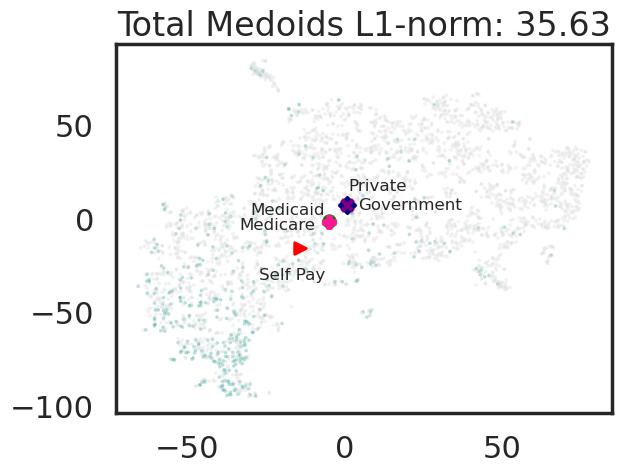

In [474]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#d1d3d4", "#1F968BFF"]),
    legend="full",
    s=7,
    alpha=0.3,
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# supervised
plt.scatter(medoid_private[0,0], medoid_private[0,1], c='darkblue', marker='D', s=70)
plt.text(medoid_private[0,0] * (1 + 0.6), medoid_private[0,1] * (1 + 1) , "Private", fontsize=12)
plt.scatter(medoid_medicaid[0,0], medoid_medicaid[0,1], c='green', marker='o', s=70)
plt.text(medoid_medicaid[0,0] * (1 + 5), medoid_medicaid[0,1] * (1 - 3) , "Medicaid", fontsize=12)
plt.scatter(medoid_government[0,0], medoid_government[0,1], c='purple', marker='x', s=70)
plt.text(medoid_government[0,0] * (1 + 5), medoid_government[0,1] * (1 -0.3) , "Government", fontsize=12)
plt.scatter(medoid_selfpay[0,0], medoid_selfpay[0,1], c='red', marker='>', s=70)
plt.text(medoid_selfpay[0,0] * (1 + 0.9), medoid_selfpay[0,1] * (1 + 1.1) , "Self Pay", fontsize=12)
plt.scatter(medoid_medicare[0,0], medoid_medicare[0,1], c='deeppink', marker='P', s=70)
plt.text(medoid_medicare[0,0] * (1 + 6), medoid_medicare[0,1] * (1 + 2) , "Medicare", fontsize=12)

# Sup
# plt.scatter(medoid_medicare[0,0], medoid_medicare[0,1], c='deeppink', marker='P', s=70)
# plt.text(medoid_medicare[0,0] * (1 + 6), medoid_medicare[0,1] * (1 + 2) , "Medicare", fontsize=12)
# plt.scatter(medoid_private[0,0], medoid_private[0,1], c='darkblue', marker='D', s=70)
# plt.text(medoid_private[0,0] * (1 + 0.6), medoid_private[0,1] * (1 + 0.5) , "Private", fontsize=12)
# plt.scatter(medoid_medicaid[0,0], medoid_medicaid[0,1], c='green', marker='o', s=70)
# plt.text(medoid_medicaid[0,0] * (1 + 5), medoid_medicaid[0,1] * (1 - 0.8) , "Medicaid", fontsize=12)
# plt.scatter(medoid_government[0,0], medoid_government[0,1], c='purple', marker='x', s=70)
# plt.text(medoid_government[0,0] * (1 + 0.6), medoid_government[0,1] * (1 - 0.5) , "Government", fontsize=12)
# plt.scatter(medoid_selfpay[0,0], medoid_selfpay[0,1], c='red', marker='>', s=70)
# plt.text(medoid_selfpay[0,0] * (1 + 0.9), medoid_selfpay[0,1] * (1 + 1.1) , "Self Pay", fontsize=12)

# plt.legend(title='ŷ')
dist = distance.cityblock(medoid_selfpay_or, medoid_medicaid_or) + distance.cityblock(medoid_medicaid_or, medoid_government_or) + distance.cityblock(medoid_medicaid_or, medoid_private_or) + distance.cityblock(medoid_medicaid_or, medoid_medicare_or) 
plt.title('Total Medoids L1-norm: {}'.format("%.2f" % dist))
#  loc='upper left',
plt.legend('', frameon=False)

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-insurance-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Point closest to mean Female vs Male (custom implementation)

In [122]:
# Before dimensionality reduction -> find the mean point (centroid)
print("X shape: {}".format(intermediate_representation.shape))
f_mean = get_mean(intermediate_representation[female_rows,:])
f_mean = np.reshape(f_mean, (1,-1))
m_mean = get_mean(intermediate_representation[male_rows,:])
m_mean = np.reshape(m_mean, (1,-1))
print(f_mean.shape)

X shape: (3236, 96)
(1, 96)


In [123]:
# Before dimensionality reduction -> find the closest existing point to the mean (possibly medoid)
from sklearn.metrics import pairwise_distances_argmin_min
# print("Centroid shape: {} - Data shape: {}".format(f_mean.shape, intermediate_representation[female_rows,:].shape))
closest_f_index, closest_f_dist = pairwise_distances_argmin_min(f_mean, intermediate_representation[female_rows,:])
closest_f = intermediate_representation[closest_f_index,:]
# print("Point closest to the female centroid: {}".format(closest_f))
closest_m_index, closest_m_dist = pairwise_distances_argmin_min(m_mean, intermediate_representation[male_rows,:])
closest_m = intermediate_representation[closest_m_index,:]

In [124]:
from scipy.spatial import distance
from scipy.spatial.distance import cityblock
print("Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): {}".format(distance.euclidean(closest_f, closest_m)))
print("Manhattan Distance between median male and female in the original space: {}".format(distance.cityblock(closest_f, closest_m)))

Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): 10.46188735961914
Manhattan Distance between median male and female in the original space: 45.65235137939453


In [34]:
# in the lower-dimensional space -> find the medoid equivalent
f_projections = projected_X[female_rows, :]
closest_f_tsne = f_projections[closest_f_index, :]
print("Female medoid: {}".format(closest_f_tsne))
m_projections = projected_X[male_rows, :]
closest_m_tsne = m_projections[closest_m_index, :]
print("Male medoid: {}".format(closest_m_tsne))

Female medoid: [[-3.7695448 -9.316665 ]]
Male medoid: [[ -4.023616 -10.414501]]


In [35]:
# reshaping
closest_m_tsne = np.reshape(closest_m_tsne, (-1,))
closest_f_tsne = np.reshape(closest_f_tsne, (-1,))
closest_m_tsne.shape

(2,)

In [36]:
print("Euclidean Distance between median male and female in the lower dimensional space: {}".format(distance.euclidean(closest_f_tsne, closest_m_tsne)))
print("Manhattan Distance between median male and female in the lower dimensional space: {}".format(distance.cityblock(closest_f_tsne, closest_m_tsne)))

Euclidean Distance between median male and female in the lower dimensional space: 1.1268527507781982
Manhattan Distance between median male and female in the lower dimensional space: 1.35190749168396


findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.


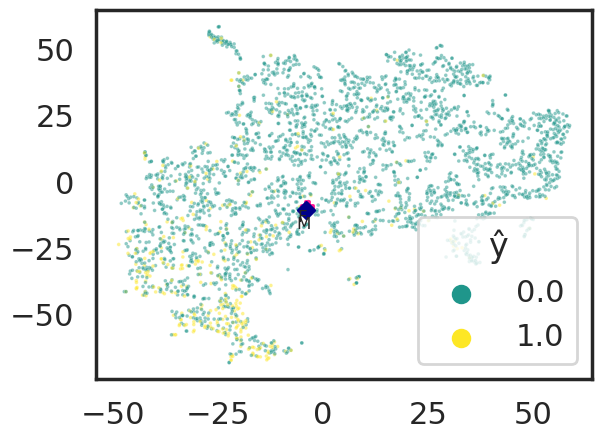

In [37]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=7,
    alpha=0.5,
)
fp = plt.scatter(closest_f_tsne[0], closest_f_tsne[1], c='deeppink', marker='P', s=70)
plt.text(closest_f_tsne[0] * (1 + 0.6), closest_f_tsne[1] * (1 + 0.6) , "F", fontsize=12)
mp = plt.scatter(closest_m_tsne[0], closest_m_tsne[1], c='darkblue', marker='D', s=70)
plt.text(closest_m_tsne[0] * (1 + 0.6), closest_m_tsne[1] * (1 + 0.7) , "M", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

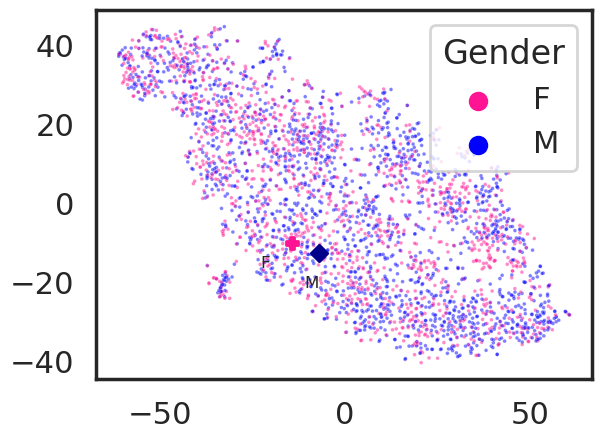

In [158]:
plt.clf()
color_coding = test_listfile["color_encoding_gender"].apply(lambda c: "F" if c=="ŷ (F)" else "M")
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=color_coding,
    palette=sns.color_palette(["deeppink", "blue"]),
    legend="full",
    s=7,
    alpha=0.5,
)

fp = plt.scatter(closest_f_tsne[0], closest_f_tsne[1], c='deeppink', marker='P', s=70)
plt.text(closest_f_tsne[0] * (1 + 0.6), closest_f_tsne[1] * (1 + 0.6) , "F", fontsize=12)
mp = plt.scatter(closest_m_tsne[0], closest_m_tsne[1], c='darkblue', marker='D', s=70)
plt.text(closest_m_tsne[0] * (1 + 0.6), closest_m_tsne[1] * (1 + 0.7) , "M", fontsize=12)
plt.legend(title='Gender')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid-2.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

# Gendered test set

In [105]:
f_test = test[0][test_listfile.GENDER == "F"]
f_test_y = test[1][test_listfile.GENDER == "F"]
m_test = test[0][test_listfile.GENDER == "M"]
m_test_y = test[1][test_listfile.GENDER == "M"]

In [106]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(f_test, batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()

(1439, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

In [107]:
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)
projected_X

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1439 samples in 0.001s...
[t-SNE] Computed neighbors for 1439 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1439
[t-SNE] Computed conditional probabilities for sample 1439 / 1439
[t-SNE] Mean sigma: 0.289101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.368942
[t-SNE] KL divergence after 1000 iterations: 1.328500


array([[-23.17241 ,  20.819963],
       [-15.45338 ,   4.541809],
       [ 11.472048,  -4.679468],
       ...,
       [ -4.124952,  -3.709606],
       [ -5.993708, -15.990616],
       [ 11.176348,  -2.190732]], dtype=float32)

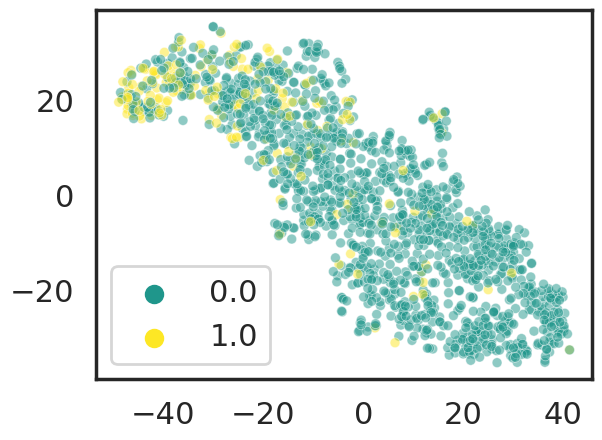

In [108]:
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=f_test_y[:,1],
    # palette=sns.color_palette(["#1F968BFF", "#FDE725FF", "#d1d3d4"],
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-f.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

In [109]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(m_test, batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)


(1797, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

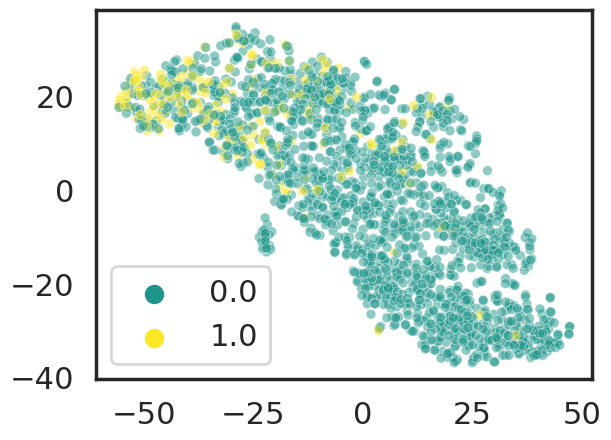

In [110]:
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=m_test_y[:,1],
    # palette=sns.color_palette(["#1F968BFF", "#FDE725FF"], num_classes),
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-m.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Age-based Test

In [130]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0
...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0


In [131]:
l65_test = test[0][test_listfile.AGE == 1]
l65_test_y = test[1][test_listfile.AGE == 1]
m65_test = test[0][test_listfile.AGE == 0]
m65_test_y = test[1][test_listfile.AGE == 0]

In [132]:
l65_test

array([[[ 1.        ,  0.        , -0.05767026, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        , -0.08609151, ...,  1.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        , -0.07661776, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 1.        ,  0.        , -0.06714401, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        , -0.06714401, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        , -0.06714401, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        ,  0.        , -0.01030151, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        , -0.00556463, ...,  1.        ,
          1.        ,  0.        ],
        [ 1.        ,  0.        ,  0.03706724, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 1.        ,  0.        ,  0.05601474, ...,  

(1440, 96)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1440 samples in 0.001s...
[t-SNE] Computed neighbors for 1440 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1440
[t-SNE] Computed conditional probabilities for sample 1440 / 1440
[t-SNE] Mean sigma: 0.852597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.800880
[t-SNE] KL divergence after 1000 iterations: 0.972528


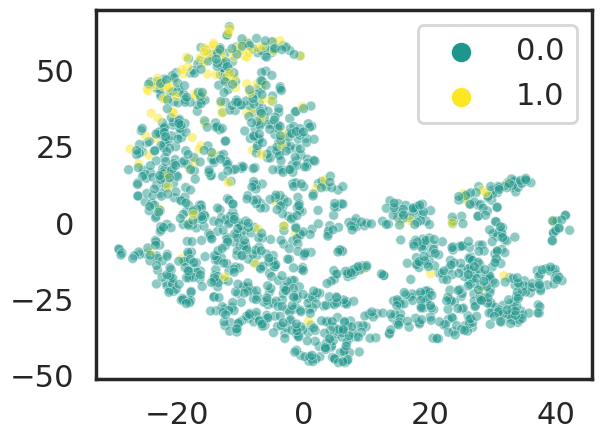

In [133]:
# <65
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(l65_test, batch_size=600)
print(intermediate_representation.shape)

tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)

graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=l65_test_y[:,1],
    # palette=sns.color_palette("bright", num_classes),
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-l65.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

(1796, 96)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1796 samples in 0.000s...
[t-SNE] Computed neighbors for 1796 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1796
[t-SNE] Computed conditional probabilities for sample 1796 / 1796
[t-SNE] Mean sigma: 0.815548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.446320
[t-SNE] KL divergence after 1000 iterations: 1.077271


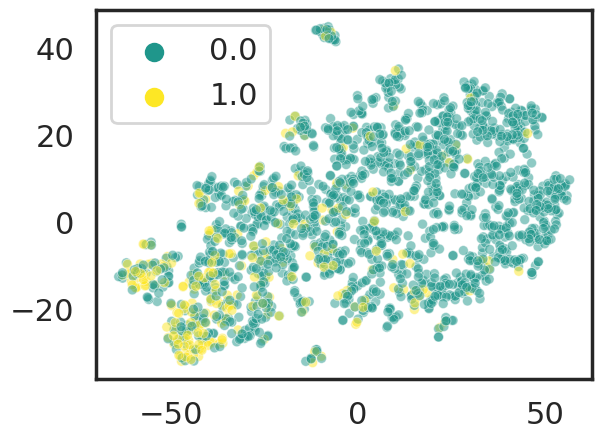

In [134]:
# <65
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(m65_test, batch_size=600)
print(intermediate_representation.shape)

tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)

graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=m65_test_y[:,1],
    # palette=sns.color_palette("bright", num_classes),
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-m65.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Pairwise Distance Density Plots
### Gender

In [140]:
intra_male_dist = []
for male1 in intermediate_representation[male_rows,:]:
    for male2 in intermediate_representation[male_rows,:]:
        intra_male_dist.append(distance.cityblock(male1, male2))
intra_male_dist

[0.0,
 7.209934,
 18.433815,
 14.669724,
 18.253736,
 12.643316,
 5.478281,
 7.7759027,
 5.9810524,
 6.9476004,
 16.445938,
 8.519565,
 15.976933,
 4.44664,
 17.553381,
 15.97014,
 12.563166,
 9.098885,
 8.37019,
 7.231386,
 7.1889133,
 5.263855,
 9.722931,
 7.8936024,
 12.087844,
 15.031126,
 5.322055,
 8.699753,
 8.291945,
 6.3863077,
 4.6693935,
 9.622971,
 24.00296,
 7.208867,
 6.012184,
 6.5940075,
 7.6895313,
 4.806755,
 16.835117,
 4.606004,
 7.5970545,
 6.5047398,
 9.323156,
 6.4710503,
 5.813948,
 14.253028,
 6.926344,
 6.427088,
 4.8575134,
 4.8564663,
 6.335943,
 8.233923,
 4.4380937,
 5.4276195,
 5.958747,
 4.6817946,
 23.657818,
 8.419208,
 10.942496,
 4.832224,
 12.068876,
 6.4617906,
 12.593794,
 6.501994,
 6.453411,
 8.95223,
 8.036602,
 4.4011703,
 4.452877,
 8.198322,
 11.843584,
 5.638167,
 8.377258,
 6.8448176,
 7.9743857,
 5.227051,
 7.2500353,
 11.689697,
 14.585222,
 19.45847,
 10.400934,
 7.9251795,
 15.551088,
 12.993982,
 13.125587,
 6.0874367,
 10.471455,
 5.

In [141]:
inter_male_dist = []
for male1 in intermediate_representation[male_rows,:]:
    for female2 in intermediate_representation[female_rows,:]:
        inter_male_dist.append(distance.cityblock(male1, female2))

In [142]:
intra_male_dist_df = pd.DataFrame(intra_male_dist, columns=['dist'])
intra_male_dist_df.loc[:, 'label'] = 'Intra-male'
inter_male_dist_df = pd.DataFrame(inter_male_dist, columns=['dist'])
inter_male_dist_df.loc[:, 'label'] = 'Inter-male'
df = pd.concat([intra_male_dist_df, inter_male_dist_df])
df.reset_index(inplace=True, drop=True)
df.head()

,dist,label
0,0.000000,Intra-male
1,7.209934,Intra-male
2,18.433815,Intra-male
3,14.669724,Intra-male
4,18.253736,Intra-male


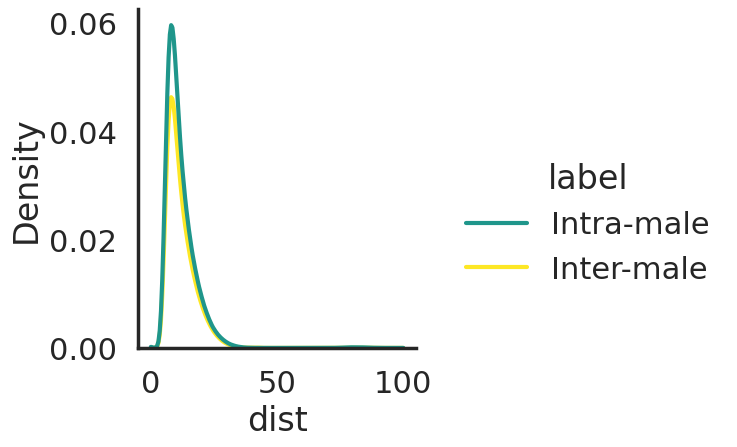

In [143]:
sns.displot(data=df, x='dist', hue='label', kind="kde", clip=(0, 100))

In [144]:
df.label.value_counts()

Intra-male    3229209
Inter-male    2585883
Name: label, dtype: int64

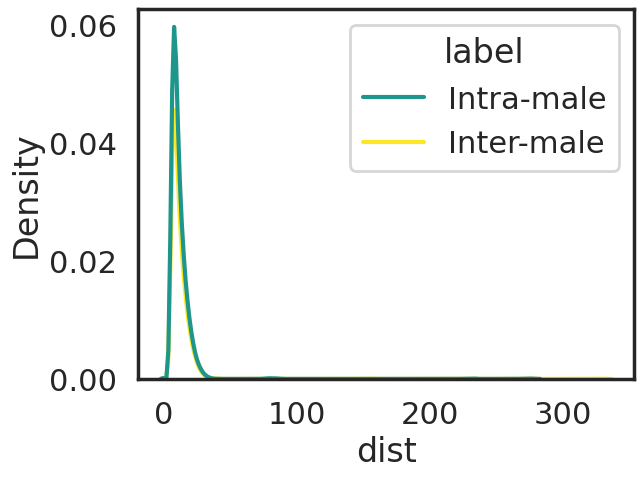

In [145]:
sns.kdeplot(data=df, x='dist', hue="label")

In [153]:
pd.to_pickle(df, 'df-{}-dist-gender-best-worst.pkl'.format(model_name))

## Ethnicity

In [148]:
test_listfile.ETHNICITY.value_counts()

WHITE                                                       2303
UNKNOWN/NOT SPECIFIED                                        283
BLACK/AFRICAN AMERICAN                                       279
HISPANIC OR LATINO                                            90
OTHER                                                         69
UNABLE TO OBTAIN                                              43
ASIAN                                                         36
PATIENT DECLINED TO ANSWER                                    28
WHITE - RUSSIAN                                               15
ASIAN - CHINESE                                               14
HISPANIC/LATINO - PUERTO RICAN                                12
BLACK/CAPE VERDEAN                                             9
WHITE - OTHER EUROPEAN                                         9
ASIAN - ASIAN INDIAN                                           8
MULTI RACE ETHNICITY                                           7
HISPANIC/LATINO - DOMINIC

In [149]:
intra_black_dist = []
for med1 in intermediate_representation[black_rows,:]:
    for med2 in intermediate_representation[black_rows,:]:
        intra_black_dist.append(distance.cityblock(med1, med2))
intra_black_dist

[0.0,
 7.940523,
 18.10505,
 17.14216,
 13.176859,
 12.540918,
 11.9329815,
 24.378468,
 12.551109,
 17.103928,
 18.559834,
 15.792938,
 26.989002,
 21.671219,
 18.83282,
 18.441193,
 17.500175,
 14.4597,
 23.16457,
 12.51913,
 9.577595,
 12.235674,
 18.25824,
 14.106801,
 15.561768,
 13.621928,
 12.407635,
 14.940946,
 19.087847,
 9.874686,
 11.906533,
 10.70885,
 8.72093,
 20.690697,
 23.345448,
 21.012112,
 18.537653,
 22.298428,
 11.156385,
 12.1097765,
 13.386812,
 11.21185,
 16.168524,
 14.274856,
 16.068409,
 14.859639,
 14.402765,
 11.399063,
 13.577417,
 16.74028,
 10.492586,
 10.948842,
 8.050887,
 17.258152,
 19.237997,
 10.586826,
 20.566208,
 7.273023,
 10.963194,
 11.034021,
 8.568017,
 19.412838,
 17.2836,
 18.845886,
 25.60712,
 16.794651,
 19.985262,
 7.9381046,
 7.3757896,
 14.1754875,
 7.0744557,
 17.281113,
 16.74119,
 8.001184,
 20.848898,
 19.917261,
 11.107287,
 18.749245,
 16.61565,
 8.489855,
 15.405039,
 18.367556,
 10.937,
 22.790117,
 18.812685,
 14.742243,


In [150]:
inter_black_dist = []
black_df = test_listfile.index.isin(black_rows)
for med1 in intermediate_representation[black_rows, :]:
    # for med2 in intermediate_representation[hispanic_rows, :]:
    for med2 in intermediate_representation[~black_df, :]:
        inter_black_dist.append(distance.cityblock(med1, med2))
inter_black_dist

[6.850404,
 12.086798,
 18.433815,
 15.22534,
 15.633894,
 19.038181,
 18.020226,
 13.208469,
 18.414448,
 10.059971,
 21.191591,
 8.565141,
 9.389115,
 19.369667,
 18.494936,
 22.000854,
 22.76711,
 21.227997,
 7.613394,
 13.979669,
 20.490398,
 11.08058,
 18.101494,
 28.030556,
 13.303046,
 9.365122,
 12.631878,
 20.661036,
 6.7470117,
 13.500689,
 18.2761,
 9.621603,
 9.451424,
 16.688026,
 6.869091,
 18.926666,
 13.022936,
 10.226247,
 11.322136,
 12.495611,
 13.513453,
 15.264023,
 18.7575,
 12.290089,
 26.254742,
 9.376342,
 15.754926,
 12.909916,
 9.597376,
 16.087784,
 11.2552,
 12.476058,
 10.335111,
 6.955863,
 21.805296,
 23.871113,
 14.176987,
 14.372942,
 21.183456,
 18.698185,
 19.269447,
 19.271475,
 8.927195,
 10.236747,
 13.409215,
 11.564989,
 10.308837,
 16.267803,
 16.043575,
 11.3951645,
 15.493707,
 22.917446,
 15.992623,
 19.207848,
 8.66128,
 17.241144,
 14.907972,
 15.974037,
 25.556335,
 16.137901,
 21.49514,
 14.426818,
 23.137247,
 23.307125,
 10.715323,
 13

In [151]:
intra_black_dist_df = pd.DataFrame(intra_black_dist, columns=['dist'])
intra_black_dist_df.loc[:, 'label'] = 'Intra-Black'
inter_black_dist_df = pd.DataFrame(inter_black_dist, columns=['dist'])
inter_black_dist_df.loc[:, 'label'] = 'Inter-Black'
df = pd.concat([intra_black_dist_df, inter_black_dist_df])
df.reset_index(inplace=True, drop=True)
df.loc[:, 'model'] = 'SSL'
df.head()

,dist,label,model
0,0.000000,Intra-Black,SSL
1,7.940523,Intra-Black,SSL
2,18.105049,Intra-Black,SSL
3,17.142160,Intra-Black,SSL
4,13.176859,Intra-Black,SSL


In [152]:
pd.to_pickle(df, 'df-{}-dist-ethnicity.pkl'.format(model_name))

### Insurance

In [15]:
test_listfile.INSURANCE.value_counts()

Medicare      1903
Private        978
Medicaid       236
Government      83
Self Pay        36
Name: INSURANCE, dtype: int64

In [16]:
intra_medicaid_dist = []
for med1 in intermediate_representation[medicaid_rows,:]:
    for med2 in intermediate_representation[medicaid_rows,:]:
        intra_medicaid_dist.append(distance.cityblock(med1, med2))
intra_medicaid_dist

[0.0,
 37.19056,
 49.540085,
 27.656334,
 48.53019,
 40.65668,
 46.531494,
 36.476334,
 26.002771,
 34.48296,
 55.13231,
 39.209457,
 40.376137,
 40.128803,
 57.286907,
 48.34414,
 61.184975,
 39.422295,
 50.973946,
 53.611214,
 33.359753,
 22.259518,
 31.750656,
 34.482243,
 36.879692,
 53.400387,
 61.263756,
 57.402985,
 37.46457,
 38.162956,
 45.02464,
 53.438084,
 33.378677,
 35.665943,
 31.805286,
 47.428024,
 34.507324,
 54.080147,
 40.65426,
 87.3813,
 38.156235,
 26.616007,
 33.847008,
 48.581417,
 25.622438,
 29.434902,
 42.037888,
 128.04327,
 52.445312,
 47.405357,
 53.495327,
 45.69437,
 39.290504,
 44.39067,
 41.41893,
 44.11515,
 41.33139,
 47.0891,
 34.484608,
 43.658936,
 52.369198,
 44.335938,
 55.655754,
 45.259277,
 36.155403,
 40.76596,
 33.210415,
 33.54808,
 28.597528,
 48.62905,
 50.662373,
 35.64915,
 45.112762,
 43.88443,
 46.439587,
 38.792755,
 49.997963,
 52.78832,
 24.805534,
 41.82811,
 40.80532,
 38.051434,
 49.593857,
 39.594772,
 41.7928,
 40.995865,
 2

In [17]:
inter_medicaid_dist = []
medicaid_df = test_listfile.index.isin(medicaid_rows)
for med1 in intermediate_representation[medicaid_rows, :]:
    for med2 in intermediate_representation[selfpay_rows, :]:
    # for med2 in intermediate_representation[~medicaid_df, :]:
        inter_medicaid_dist.append(distance.cityblock(med1, med2))

In [18]:
intra_medicaid_dist_df = pd.DataFrame(intra_medicaid_dist, columns=['dist'])
intra_medicaid_dist_df.loc[:, 'label'] = 'Intra-medicaid'
inter_medicaid_dist_df = pd.DataFrame(inter_medicaid_dist, columns=['dist'])
inter_medicaid_dist_df.loc[:, 'label'] = 'Inter-medicaid'
df = pd.concat([intra_medicaid_dist_df, inter_medicaid_dist_df])
df.reset_index(inplace=True, drop=True)
df.loc[:, 'model'] = 'SSL'
df.head()

,dist,label,model
0,0.000000,Intra-medicaid,SSL
1,37.190559,Intra-medicaid,SSL
2,49.540085,Intra-medicaid,SSL
3,27.656334,Intra-medicaid,SSL
4,48.530190,Intra-medicaid,SSL


findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.


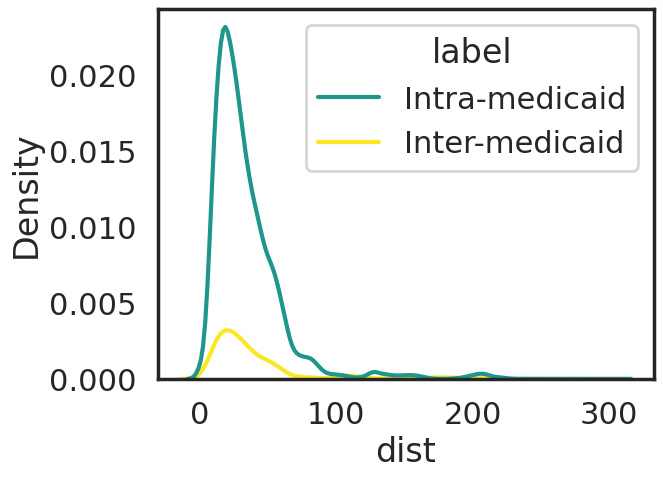

In [19]:
sns_plot = sns.kdeplot(data=df, x='dist', hue="label")
sns_plot.figure.savefig(os.path.join('results', dataset, 'pairwise-dist-{}-insurance.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

In [326]:
pd.to_pickle(df, 'df-{}-dist-all.pkl'.format(model_name))

## Plot together

### Insurance

In [20]:
# df_sup = pd.read_pickle('df-sup-dist-all.pkl')
df_sup = pd.read_pickle('df-sup-dist-best-worst.pkl')

df_sup.loc[:, 'model'] = 'Sup.'
df_all = pd.concat([df, df_sup])
df_all.reset_index(inplace=True, drop=True)
df_all

,dist,label,model
0,0.000000,Intra-medicaid,SSL
1,37.190559,Intra-medicaid,SSL
2,49.540085,Intra-medicaid,SSL
3,27.656334,Intra-medicaid,SSL
4,48.530190,Intra-medicaid,SSL
...,...,...,...
128379,14.650194,Inter-medicaid,Sup.
128380,11.428015,Inter-medicaid,Sup.
128381,11.713991,Inter-medicaid,Sup.
128382,14.302126,Inter-medicaid,Sup.


In [21]:
df_all.model.value_counts()

SSL     64192
Sup.    64192
Name: model, dtype: int64

In [22]:
df_all.rename({'dist':'Distance', 'label':'Group'}, axis=1, inplace=True)
df_all

,Distance,Group,model
0,0.000000,Intra-medicaid,SSL
1,37.190559,Intra-medicaid,SSL
2,49.540085,Intra-medicaid,SSL
3,27.656334,Intra-medicaid,SSL
4,48.530190,Intra-medicaid,SSL
...,...,...,...
128379,14.650194,Inter-medicaid,Sup.
128380,11.428015,Inter-medicaid,Sup.
128381,11.713991,Inter-medicaid,Sup.
128382,14.302126,Inter-medicaid,Sup.


In [47]:
mean_dist = df_all.groupby(['model', 'Group']).mean()
mean_dist
# mean_dist.loc["SSL"].loc["Inter-medicaid"]

Distance
model Group                    
SSL   Inter-medicaid  37.275352
      Intra-medicaid  34.047565
Sup.  Inter-medicaid  12.430895
      Intra-medicaid  12.135487

In [60]:
mean_dist.loc["SSL"].loc["Inter-medicaid", "Distance"]

37.275352

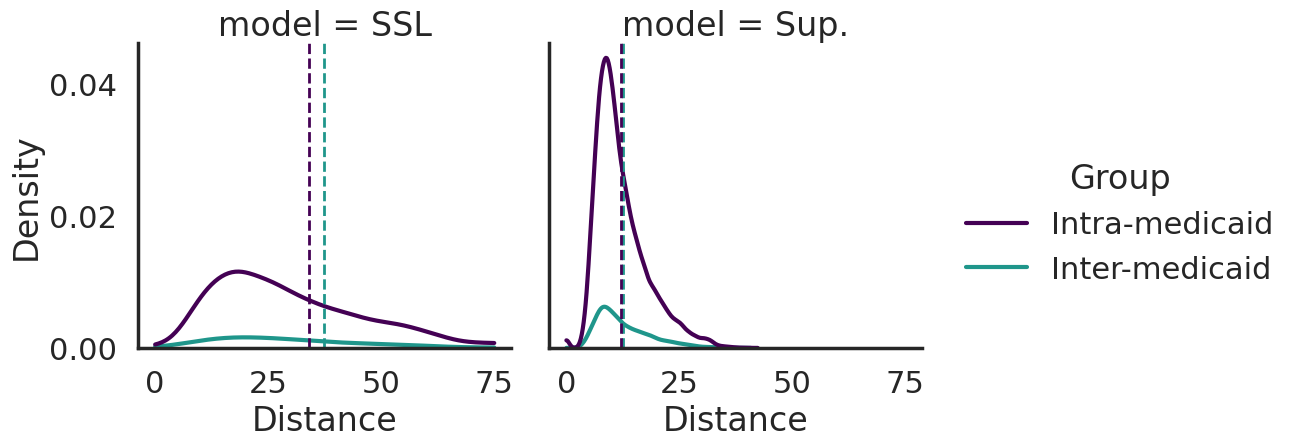

In [88]:
sns_plot = sns.displot(data=df_all, x='Distance', hue="Group", col='model', kind='kde', clip=(0, 75), palette=sns.color_palette(["#440154FF", "#1F968BFF"]))
axes = sns_plot.fig.axes

pl1 = axes[0]
pl2 = axes[1]

pl1.axvline(x=mean_dist.loc["SSL"].loc["Inter-medicaid", "Distance"], color=sns.color_palette(["#440154FF", "#1F968BFF"])[1], linestyle='--', lw=2) 
pl1.axvline(x=mean_dist.loc["SSL"].loc["Intra-medicaid", "Distance"], color=sns.color_palette(["#440154FF", "#1F968BFF"])[0], linestyle='--', lw=2) 
pl2.axvline(x=mean_dist.loc["Sup."].loc["Inter-medicaid", "Distance"], color=sns.color_palette(["#440154FF", "#1F968BFF"])[1], linestyle='--', lw=2) 
pl2.axvline(x=mean_dist.loc["Sup."].loc["Intra-medicaid", "Distance"], color=sns.color_palette(["#440154FF", "#1F968BFF"])[0], linestyle='--', lw=2) 
sns_plot.figure.savefig(os.path.join('results', dataset, 'pairwise-dist-{}-insurance.pdf'.format('all')), bbox_inches='tight', transparent=True)

In [72]:
axes[0]

### Ethnicity

In [127]:
df_sup = pd.read_pickle('df-sup-dist-ethnicity-best-worst.pkl')

df_sup.loc[:, 'model'] = 'Sup.'
df_all = pd.concat([df, df_sup])
df_all.reset_index(inplace=True, drop=True)
df_all

,dist,label,model
0,0.000000,Intra-Black,SSL
1,36.974747,Intra-Black,SSL
2,53.176044,Intra-Black,SSL
3,55.471867,Intra-Black,SSL
4,34.313072,Intra-Black,SSL
...,...,...,...
1066515,9.519918,Inter-Black,Sup.
1066516,13.253488,Inter-Black,Sup.
1066517,10.377148,Inter-Black,Sup.
1066518,13.567165,Inter-Black,Sup.


In [128]:
df_all.model.value_counts()

SSL     948148
Sup.    118372
Name: model, dtype: int64

In [129]:
df_all.rename({'dist':'Distance', 'label':'Group'}, axis=1, inplace=True)
mean_dist = df_all.groupby(['model', 'Group']).mean()
mean_dist

Distance
model Group                 
SSL   Inter-Black  53.949394
      Intra-Black  71.547127
Sup.  Inter-Black  12.326105
      Intra-Black  12.925549

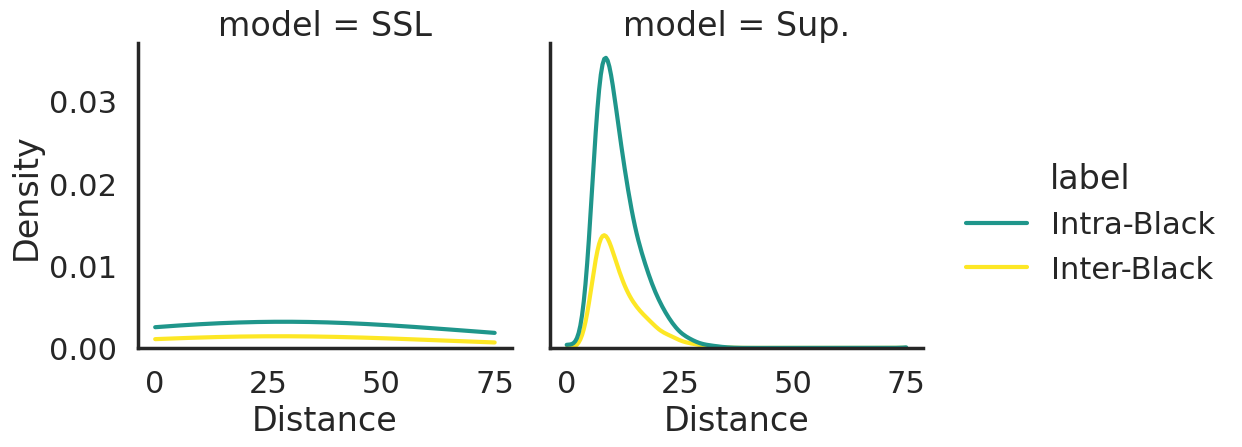

In [108]:
g = sns_plot = sns.displot(data=df_all, x='dist', hue="label", col='model', kind='kde', clip=(0, 75))
g.set_axis_labels("Distance")
sns_plot.figure.savefig(os.path.join('results', dataset, 'pairwise-dist-{}-ethnicity.pdf'.format('best-worst')), bbox_inches='tight', transparent=True)

### Gender

In [155]:
df_sup = pd.read_pickle('df-sup-dist-gender-best-worst.pkl')

df_sup.loc[:, 'model'] = 'Sup.'
df_all = pd.concat([df, df_sup])
df_all.reset_index(inplace=True, drop=True)
df_all

,dist,label,model
0,0.000000,Intra-Black,SSL
1,7.940523,Intra-Black,SSL
2,18.105049,Intra-Black,SSL
3,17.142160,Intra-Black,SSL
4,13.176859,Intra-Black,SSL
...,...,...,...
1896291,10.352543,Inter-Black,Sup.
1896292,9.752808,Inter-Black,Sup.
1896293,15.782801,Inter-Black,Sup.
1896294,14.082317,Inter-Black,Sup.


In [156]:
df_all.model.value_counts()

SSL     948148
Sup.    948148
Name: model, dtype: int64

In [157]:
df_all.rename({'dist':'Distance', 'label':'Group'}, axis=1, inplace=True)
mean_dist = df_all.groupby(['model', 'Group']).mean()
mean_dist

Distance
model Group                 
SSL   Inter-Black  12.647071
      Intra-Black  12.925549
Sup.  Inter-Black  12.647071
      Intra-Black  12.925549

In [158]:
g = sns_plot = sns.displot(data=df_all, x='dist', hue="label", col='model', kind='kde', clip=(0, 75))
g.set_axis_labels("Distance")
sns_plot.figure.savefig(os.path.join('results', dataset, 'pairwise-dist-{}-gender.pdf'.format('best-worst')), bbox_inches='tight', transparent=True)

ValueError: Could not interpret value `dist` for parameter `x`